In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

import pyForwardFolding as pyFF

In [2]:
data = pd.read_parquet("../../NNMFit_testdata/src/NNMFit_testdata/data/datasets/Toise_ToyTracks/dataframe.parquet")




In [3]:
ana = pyFF.config.analysis_from_config("test_relaxed.yaml")
lik = pyFF.likelihood.PoissonLikelihood(ana)

In [4]:
model = ana.expectations["det1"].model
be = ana.expectations["det1"]

In [5]:
model_parameters = {
    "astro_norm": 1.0,
    "astro_index": 2.37,
    "atmo_norm": 1.0,
    "escale": 1.0,
    "esmear": 1.0,
    "delta_gamma": 0.0
}

In [6]:
reco_e = jnp.log10(jnp.asarray(data.reco_e)) 

summary_stat = (reco_e - jnp.min(reco_e)) / (jnp.max(reco_e) - jnp.min(reco_e))

input_variables = {
    "true_energy": jnp.asarray(data.true_e),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.reco_e)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.reco_zenith)),
    "baseline_weight": jnp.asarray(data.fluxless_weight),
    "conv_weight": jnp.asarray(data.weight_honda2006),
    "e_scaling": jnp.asarray(data.e_scaling),
    "e_smearing": jnp.asarray(data.e_smearing),
    "summary_stat": summary_stat
}

In [7]:
ana.exposed_parameters

{'astro_index', 'astro_norm', 'atmo_norm', 'delta_gamma', 'escale', 'esmear'}

In [8]:
ana.required_variables

{'e_scaling', 'e_smearing', 'summary_stat', 'true_energy'}

In [9]:
[(f.name, f.required_variables) for f in ana.expectations["det1"].model.components[1].factors]

[('atmo_norm', []),
 ('delta_gamma', ['true_energy']),
 ('snowstorm_escale', ['e_scaling']),
 ('snowstorm_esmear', ['e_smearing'])]

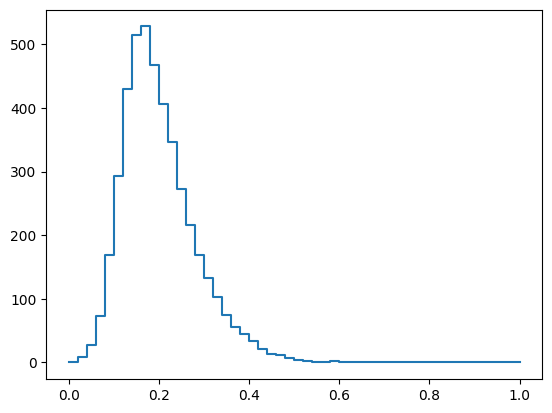

In [10]:
dataset = {"det1": input_variables}
pred = ana.evaluate(dataset, model_parameters)[0]
hsum = pred["det1"]
plt.step(be.binning.bin_edges[0], jnp.append(hsum, hsum[-1]))


In [11]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
key = jax.random.PRNGKey(0)
obs = {}
for k, v in hist.items():
    key, subkey = jax.random.split(key)
    obs[k] = jax.random.poisson(subkey, v)
obs = hist # asimov

In [12]:
lh = lik.llh(obs, dataset, model_parameters)
lh_jit = jax.jit(lik.llh)


In [13]:
def eval_for_par(par_val, par_dict):
    par_dict["escale"]= par_val
    lh = lik.llh(obs, dataset, par_dict)
    return lh

val_grad = jax.jit(jax.value_and_grad(eval_for_par, 0) )


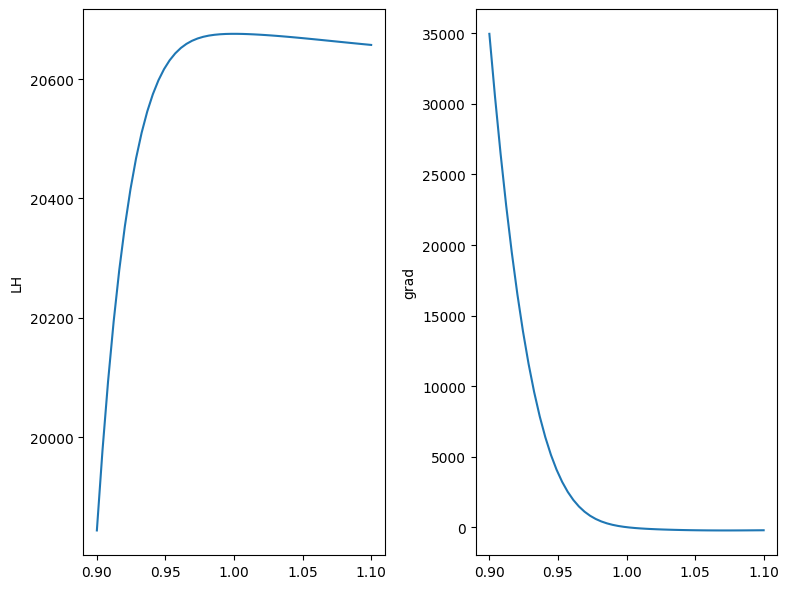

In [14]:
scan_vals = jnp.linspace(0.9, 1.1, 50)
lhs, grads = jax.vmap(val_grad, in_axes=(0, None))(scan_vals, model_parameters)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
ax1.plot(scan_vals, lhs)
ax1.set_ylabel("LH")
ax2.plot(scan_vals, grads)
ax2.set_ylabel("grad")
plt.tight_layout()

In [15]:
wrapped_lh = pyFF.minimizer.WrappedLLH(lik, obs, dataset, {}, {})

In [ ]:
dest_args = pyFF.minimizer.destructure_args(model_parameters, ana.exposed_parameters, {})
hess_func = jax.jit(jax.hessian(wrapped_lh))
hessian = hess_func(jnp.asarray(dest_args))
fisher = jnp.linalg.inv(hessian)
sns.heatmap(fisher, cmap="viridis", xticklabels=ana.exposed_parameters, yticklabels=ana.exposed_parameters)

In [22]:
fmin_and_grad = jax.jit(jax.value_and_grad(wrapped_lh))

In [49]:
import scipy.optimize

astro_scan = np.linspace(0, 3, 100)

scan_res = []

for astro in astro_scan:

    bounds = scipy.optimize.Bounds(
        [astro,      1.0, 0.9, 0.9, 0,      -1],
        [astro,      4.0, 1.1, 1.1, np.inf,  1]
    )

    res = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)
    scan_res.append(res.fun)

bounds = scipy.optimize.Bounds(
        [0,      1.0, 0.9, 0.9, 0,      -1],
        [np.inf,      4.0, 1.1, 1.1, np.inf,  1]
    )

free_fit = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)

Text(0, 0.5, 'Test Statistic')

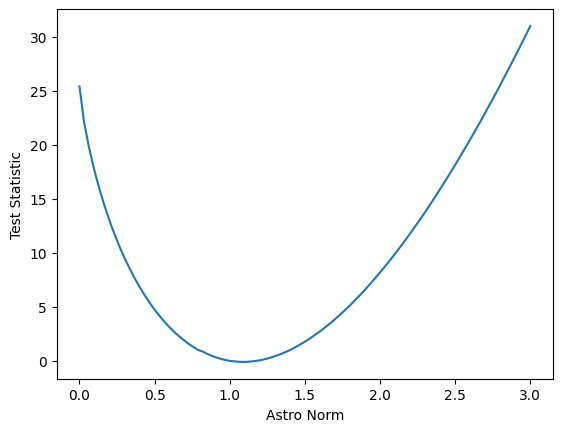

In [52]:
plt.plot(astro_scan, 2*(np.asarray(scan_res) - free_fit.fun))
plt.xlabel("Astro Norm")
plt.ylabel("Test Statistic")

In [14]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import nnx

class MLP(nnx.Module):
    """A simple CNN model."""

    def __init__(self, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(2, 32, rngs=rngs)
        self.linear2 = nnx.Linear(32, 32, rngs=rngs)
        self.out = nnx.Linear(32, 1, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.linear1(x))
        x = nnx.relu(self.linear2(x))
        x = nnx.sigmoid(self.out(x))
        return x
  

In [15]:
model = MLP(rngs=nnx.Rngs(0))

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)

nn_in = jnp.vstack([
        input_variables["log10_reco_energy"],
        input_variables["cos_reco_zenith"],]).T

def loss_fn(model: MLP):
    summary_stat = model(nn_in)
    input_variables["summary_stat"] = summary_stat
    dataset = {"det1": input_variables}
    hist, hist_ssq = ana.evaluate(dataset, model_parameters)
    obs = hist
    wrapped_lh = pyFF.minimizer.WrappedLLH(lik, obs, dataset, {}, {})
    dest_args = pyFF.minimizer.destructure_args(model_parameters, ana.exposed_parameters, {})
    #hess_func = jax.jit(jax.hessian(wrapped_lh))
    #hessian = hess_func(jnp.asarray(dest_args))
    
    grad = jax.grad(wrapped_lh)(jnp.asarray(dest_args))
    fisher = jnp.outer(grad, grad)
    cov = jnp.linalg.inv(fisher)
    ts = jnp.linalg.trace(cov)

    return ts

@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=False)
    loss, grads = grad_fn(model)
    metrics.update(loss=loss,)  
    optimizer.update(grads) 

@nnx.jit
def eval_step(model: MLP, metrics: nnx.MultiMetric):
    loss = loss_fn(model)
    metrics.update(loss=loss)  # In-place updates.


In [16]:
ts = nnx.jit(loss_fn)(model)

In [17]:
ts

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error preparing computation: Out of memory allocating 3907341534360 bytes.

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error dispatching computation: Error preparing computation: Out of memory allocating 3907341534360 bytes.

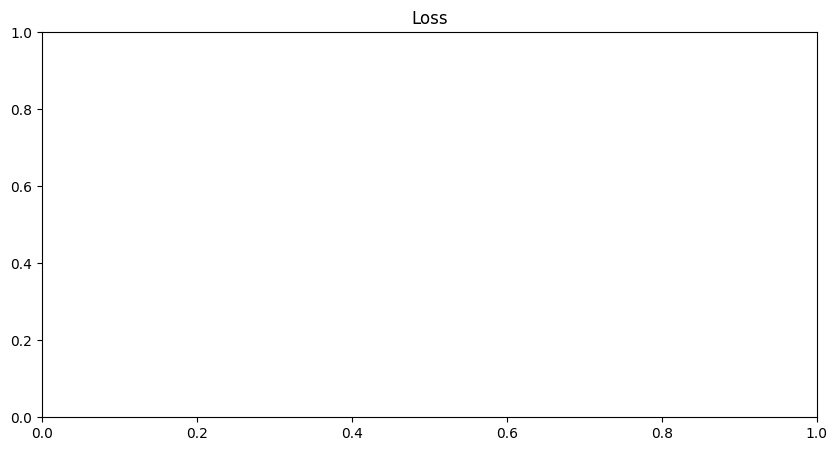

In [15]:
from IPython.display import clear_output

metrics_history = {
  'train_loss': [],
  'test_loss': [],

}

eval_every = 10
train_steps = 100

for step in range(train_steps):
    train_step(model, optimizer, metrics)
    
    if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
        # Log the training metrics.
        for metric, value in metrics.compute().items():  # Compute the metrics.
            metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
        metrics.reset()  # Reset the metrics for the test set.


        eval_step(model, metrics)
       
        # Log the test metrics.
        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset()  # Reset the metrics for the next training epoch.

        clear_output(wait=True)
        # Plot loss and accuracy in subplots
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
        ax1.set_title('Loss')
        for dataset in ('train', 'test'):
            ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
        ax1.legend()
        plt.show()

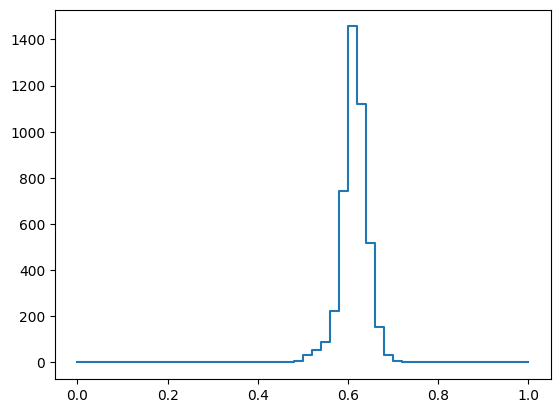

In [75]:
nn_in = jnp.vstack([
            input_variables["log10_reco_energy"],
            input_variables["cos_reco_zenith"],]).T
summary_stat = state.apply_fn({"params": state.params}, nn_in)[:, 0]
input_variables["summary_stat"] = summary_stat
dataset = {"det1": input_variables}
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
hsum = hist["det1"]
plt.step(be.binning.bin_edges[0], jnp.append(hsum, hsum[-1]))